In [13]:
import jax
import optax
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel.experimental.optim as opt
import liesel.model as lsl

We take a super simple Liesel model here

In [14]:
xval = 2.0 * jax.random.normal(jax.random.key(42), (10_000,)) + 3.0

Next, we create a train/validation/test split of the data.

In [15]:
split = opt.Split(
    position_keys=["x"],
    n=xval.size,  # full size of the axis along which we split
    n_validate=200,
    n_train=1000,
    n_test=0,  # I don't use any test data in this example
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
    # -
    # indices can be shuffled
    shuffle=True,
    seed=1,
)

# Finally, we apply the split to the position
position = {"x": xval}
data = split.split_position(position)

Next, we prepare batching.

In [16]:
bi = opt.Batches(
    position_keys=["x"],
    n=data.n_train,  # full size of the training data set.
    batch_size=256,
    shuffle=True,  # can be set to turn off shuffling in Batches.permute_indices
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
)
initial_batch = bi.get_batched_position(data.train, batch_index=0)

In [17]:
initial_batch["x"]

Array([ 1.8831078 ,  2.1016881 ,  1.7014792 ,  4.930806  ,  3.288251  ,
        2.426262  ,  1.2740598 ,  2.3242457 ,  0.35952187,  4.5264525 ,
        3.8881786 ,  3.9209538 ,  2.4460185 ,  0.6639278 ,  2.479095  ,
        2.7503107 ,  4.7061915 ,  0.8779361 ,  5.2684917 ,  6.76009   ,
        2.6295412 ,  6.0734105 ,  0.43816447,  4.7384386 ,  4.5070496 ,
        1.8843096 ,  3.0607977 ,  2.6461449 ,  0.8659246 ,  3.2387302 ,
       -1.3208795 ,  0.92147446,  3.1181557 ,  3.1955013 ,  4.7873282 ,
        2.5150888 ,  3.8943405 ,  1.4110185 ,  6.3026    ,  2.2584636 ,
        5.031295  ,  3.4752145 ,  3.528802  ,  5.24001   ,  1.1421907 ,
        4.95613   ,  6.4181547 ,  4.234089  ,  4.088835  ,  4.2154965 ,
        0.9511349 ,  0.663435  ,  3.6789913 ,  2.5761886 ,  4.1199126 ,
        3.3945317 ,  1.7390438 ,  0.5247886 ,  4.265695  ,  3.7321558 ,
        5.3166604 ,  7.0405397 ,  3.3353212 ,  4.2887044 ,  5.656828  ,
        4.283993  ,  1.3394214 ,  2.0860157 ,  1.8944882 ,  3.87

We initialize the liesel model with the first batch.

In [18]:
m = lsl.Var.new_param(0.0, name="m")
s = lsl.Var.new_param(1.0, name="s")
s.transform(tfb.Exp())
x = lsl.Var.new_obs(
    initial_batch["x"],
    distribution=lsl.Dist(tfd.Normal, loc=m, scale=s),
    name="x",
)
p = lsl.Model([x])

In [19]:
m = lsl.Var.new_param(0.0, name="m")
s = lsl.Var.new_param(1.0, name="s")
dist = lsl.Dist(tfd.Normal, loc=m, scale=s)
dist.auto_transform_params = True
x = lsl.Var.new_obs(
    initial_batch["x"],
    distribution=dist,
    name="x",
)
p = lsl.Model([x])

In [20]:
p._vars

{'x': Var(name="x"),
 's': Var(name="s"),
 's_transformed': Var(name="s_transformed"),
 'm': Var(name="m"),
 'm_transformed': Var(name="m_transformed")}

In [21]:
p._nodes

{'x_log_prob': Dist(name="x_log_prob"),
 'x_var_value': VarValue(name="x_var_value"),
 'x_value': Value(name="x_value"),
 's_var_value': VarValue(name="s_var_value"),
 's_value': Calc(name="s_value"),
 's_transformed_var_value': VarValue(name="s_transformed_var_value"),
 's_transformed_value': Value(name="s_transformed_value"),
 'm_var_value': VarValue(name="m_var_value"),
 'm_value': Calc(name="m_value"),
 'm_transformed_var_value': VarValue(name="m_transformed_var_value"),
 'm_transformed_value': Value(name="m_transformed_value"),
 '_model_log_prob': Calc(name="_model_log_prob"),
 '_model_log_prior': Calc(name="_model_log_prior"),
 '_model_log_lik': Calc(name="_model_log_lik")}

In [22]:
scale = lsl.Var.new_param(1.0, name="scale")
dist = lsl.Dist(tfd.Normal, loc=0.0, scale=scale)
dist.auto_transform_params = True  # Set via property
y = lsl.Var.new_obs(1.0, dist, name="y")
model = lsl.Model([y])

Next, we initialize our loss object.

In [23]:
loss = opt.NegLogProbLoss(
    model=p,
    split=data,
    # considers only log likelihood in validation loss for early stopping
    # to measure predictive likelihood
    # can be changed to "log_prob", if you explicitly want to also consider the prior
    validation_strategy="log_lik",
)

Next, we initialize the optimizer.

In [24]:
parameters = list(p.parameters)
optim = opt.Optimizer(parameters, optimizer=optax.adam(learning_rate=1e-2))

Next, we initialize the engine.

In [25]:
engine = opt.OptimEngine(
    loss=loss,
    batches=bi,
    split=data,
    optimizers=[optim],
    stopper=opt.Stopper(epochs=1000, patience=50, atol=0.0, rtol=1e-4),
    seed=42,
    initial_state=p.state,
    restore_best_position=True,
    prune_history=True,
    show_progress=True,
    save_position_history=True,
    progress_n_updates=100,
)

Finally, we run the optimization.

In [26]:
result = engine.fit()

Training loss: 2135.143, Validation loss: 2087.303:  38%|███▊      | 376/1000 [00:00<00:01, 419.49it/s]


Now we can inspect the loss and parameter history.

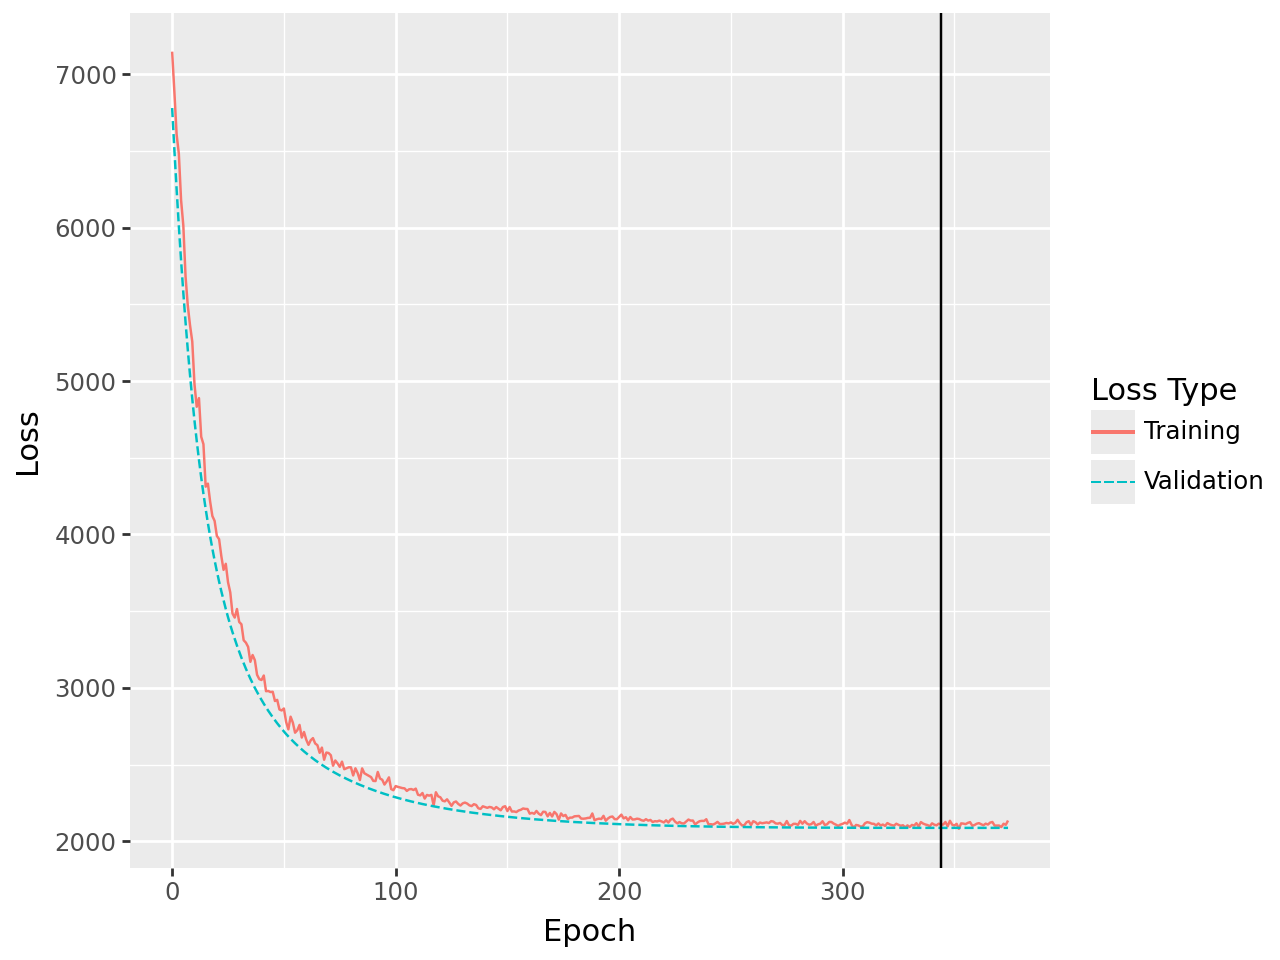

In [27]:
result.plot_loss()

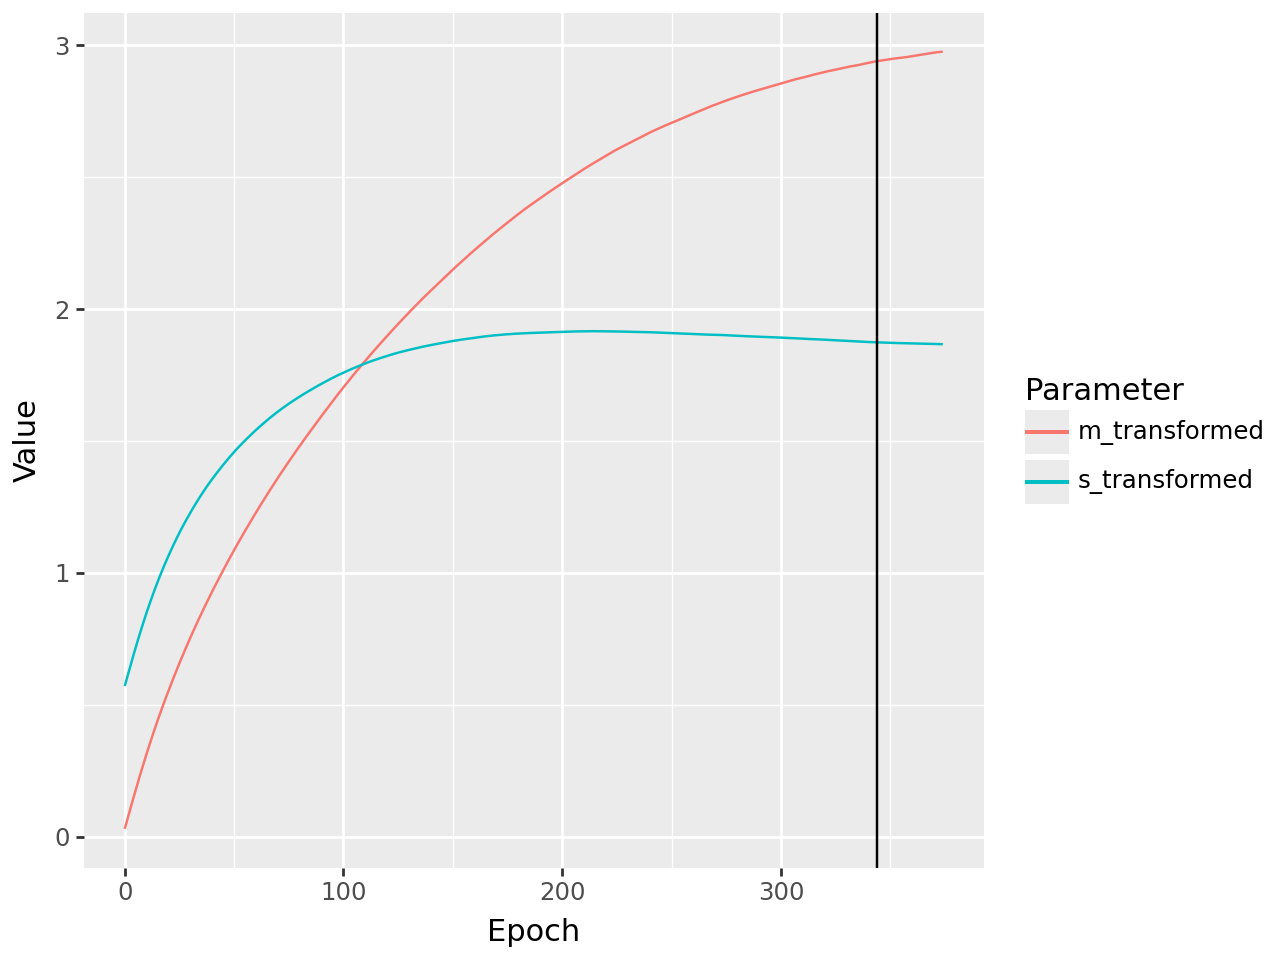

In [28]:
result.plot_params()

Plot history on the untransformed level

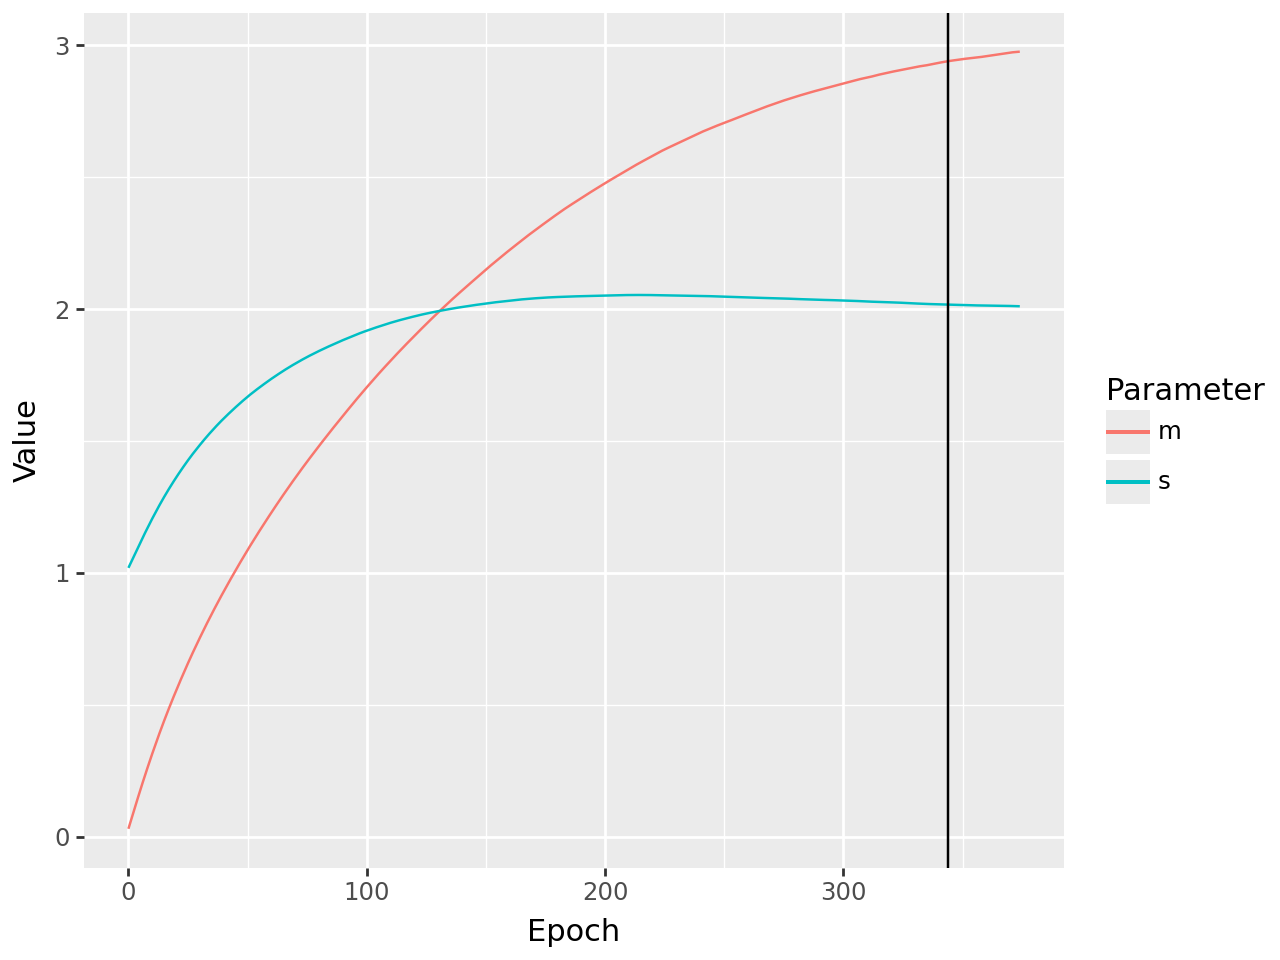

In [29]:
param_history = p.predict(result.history.position, ["m", "s"])
result.plot_params(param_history)

## Variations

### Blocked optimizers

In [30]:
opt1 = opt.Optimizer(["m"], optimizer=optax.adam(learning_rate=1e-2))
opt2 = opt.Optimizer(["s_transformed"], optimizer=optax.adam(learning_rate=1e-5))
optimizers = [opt1, opt2]

### Using L-BFGS

L-BFGS is a quasi-Newton method. It tries to approximate the curvature (inverse Hessian) of the objective. To build a good curvature estimate, it assumes you’re giving it gradients of the same underlying function each step. Therefore, you usually do not want to use batching when optimizing with L-BFGS.

In [31]:
split = opt.Split(["x"], xval.size, n_validate=10)
data = split.split_position({"x": xval})
bi = opt.Batches(
    position_keys=[],
    n=data.n_train,  # full size of the training data set.
    batch_size=None,
)

m = lsl.Var.new_param(0.0, name="m")
s = lsl.Var.new_param(1.0, name="s")
dist = lsl.Dist(tfd.Normal, loc=m, scale=s)
dist.auto_transform_params = True
x = lsl.Var.new_obs(
    data.train["x"],
    distribution=dist,
    name="x",
)
p = lsl.Model([x])

parameters = list(p.parameters)
optim = opt.LBFGS(parameters)

loss = opt.NegLogProbLoss(
    model=p,
    split=data,
    # considers only log likelihood in validation loss for early stopping
    # to measure predictive likelihood
    # can be changed to "log_prob", if you explicitly want to also consider the prior
    validation_strategy="log_lik",
)

engine = opt.OptimEngine(
    loss=loss,
    batches=bi,
    split=data,
    optimizers=[optim],
    stopper=opt.Stopper(epochs=1000, patience=50, atol=0.0, rtol=1e-4),
    seed=42,
    initial_state=p.state,
    restore_best_position=True,
    prune_history=True,
    show_progress=True,
    save_position_history=True,
    progress_n_updates=100,
)

In [32]:
result = engine.fit()

Training loss: 21011.219, Validation loss: 22263.451:   6%|▌         | 57/1000 [00:01<00:30, 30.44it/s]


L-BFGS converges very quickly, so the high patience that we used here is a bit over-the-top.

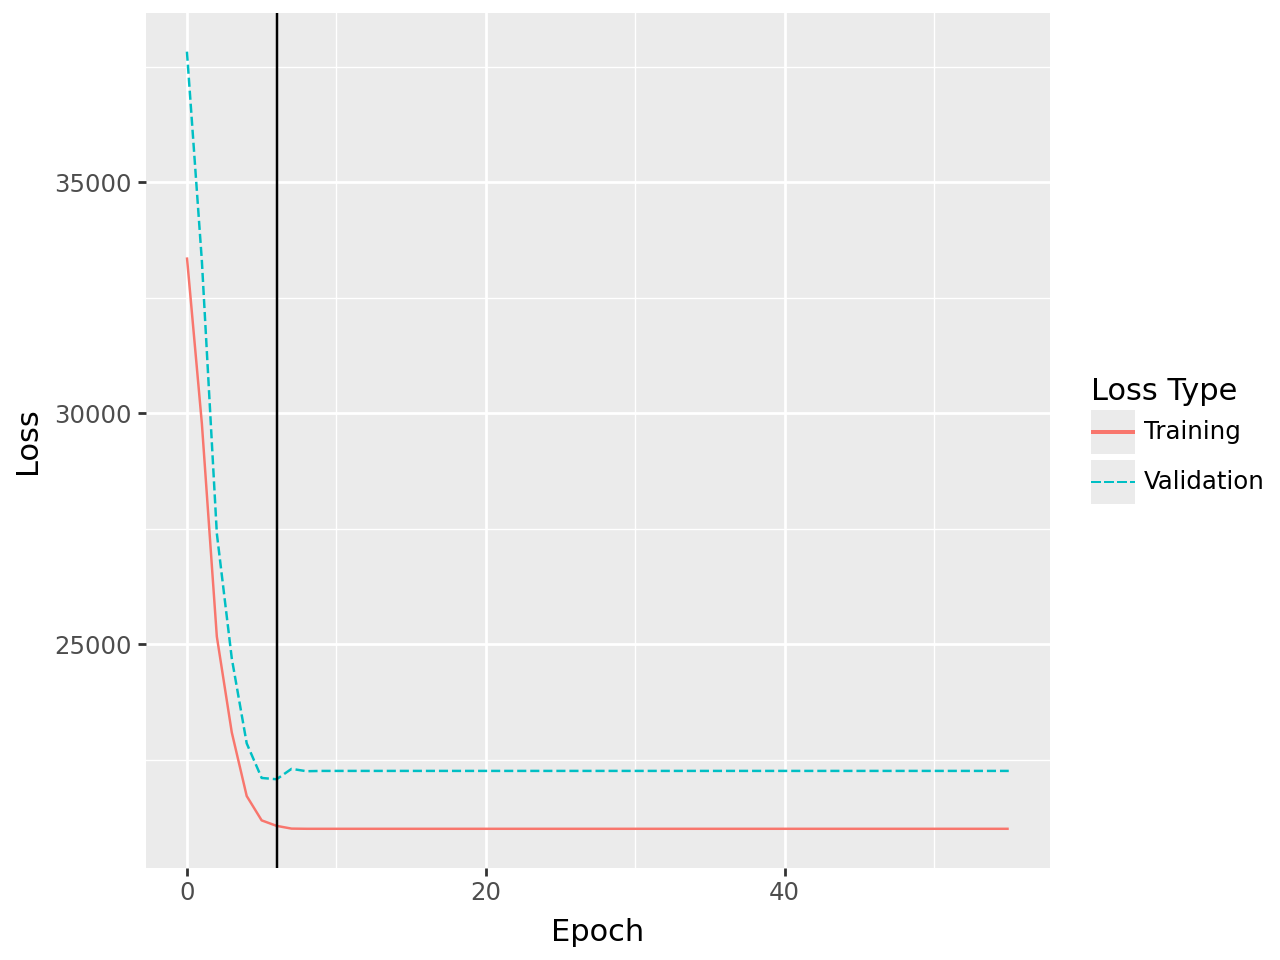

In [33]:
result.plot_loss()

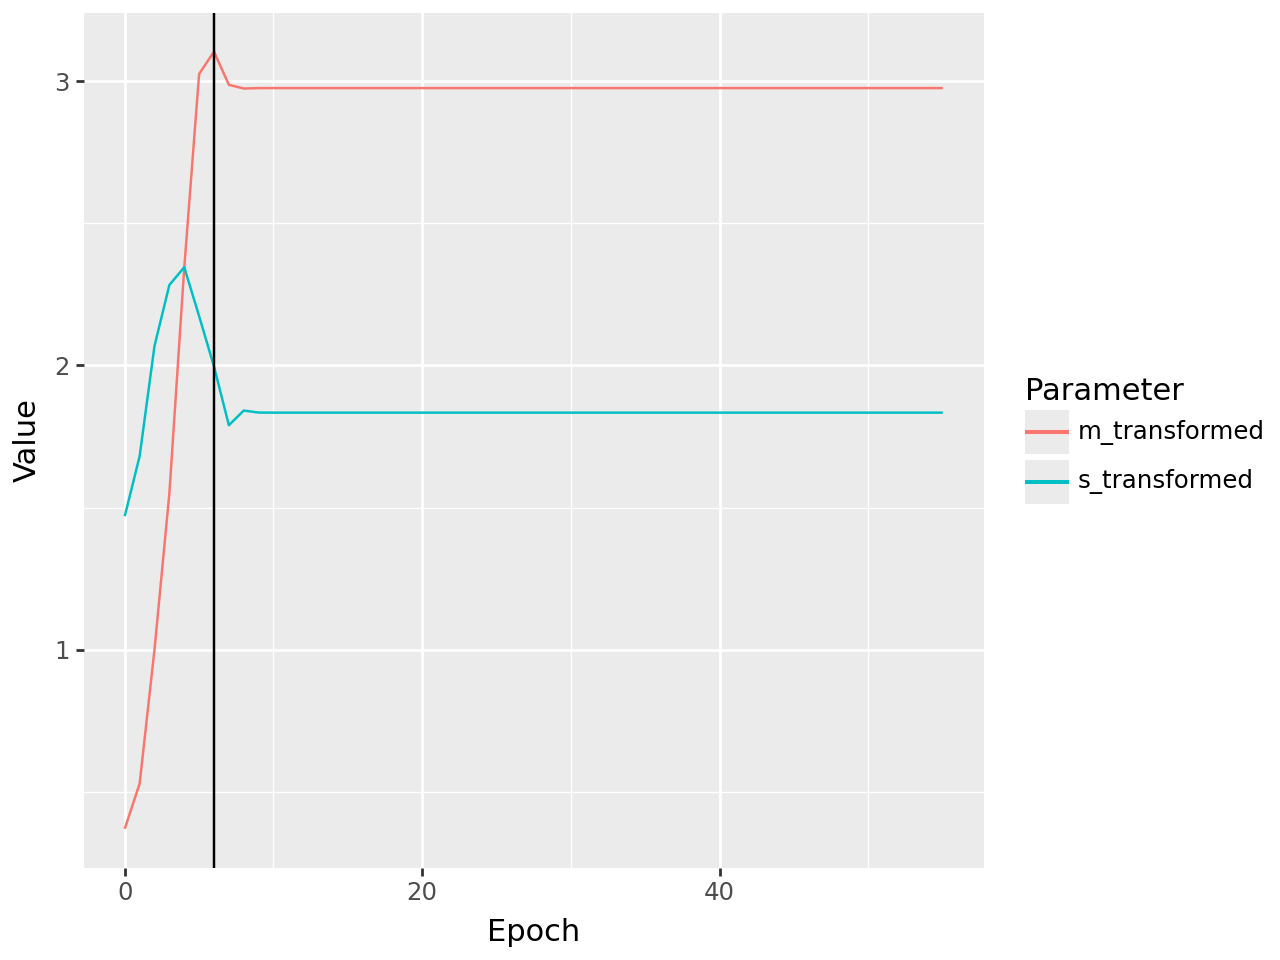

In [34]:
result.plot_params()